In [1]:
import pandas as pd
import collections
import numpy as np
import matplotlib.pyplot as plt
import folium as fo
import json

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
df=pd.read_parquet('resources/cleaned_franchises.parquet')
df.head()

DBA Name          AKA Name  License # Facility Type  \
Inspection ID                                                                  
2320519         SALAM  RESTAURANT   SALAMRESTAURANT    2002822    Restaurant   
2320509        TAQUERIA EL DORADO  TAQUERIAELDORADO    2694960    Restaurant   
2320412        DANTE'S PIZZA,INC.       DANTESPIZZA    2092884    Restaurant   
2320430          LAO PENG YOU LLC        LAOPENGYOU    2694477    Restaurant   
2320384                     ARBOR             ARBOR    2363029    Restaurant   

               Risk                  Address    Zip Inspection Date  \
Inspection ID                                                         
2320519        High  4634-4636 N KEDZIE AVE   60625      2019-10-25   
2320509        High     2114 W LAWRENCE AVE   60625      2019-10-25   
2320412        High     3028 W ARMITAGE AVE   60647      2019-10-24   
2320430        High          2020 W CHICAGO   60622      2019-10-24   
2320384        High     2545 W DIVERSEY AVE   60647      2019-10-24   

              Inspection Type             Results  ... Re-inspection  \
Inspection ID                                      ...                 
2320519             Complaint                Pass  ...          True   
2320509               License                Fail  ...          True   
2320412               Canvass                Fail  ...         False   
2320430               License  Pass w/ Conditions  ...          True   
2320384                Others  Pass w/ Conditions  ...         False   

                    Community                        Neighborhood  Ward  \
Inspection ID                                                             
2320519           ALBANY PARK              NORTH PARK,ALBANY PARK    33   
2320509        LINCOLN SQUARE                      LINCOLN SQUARE    47   
2320412          LOGAN SQUARE                        LOGAN SQUARE    32   
2320430             WEST TOWN  UKRAINIAN VILLAGE AND EAST VILLAGE     2   
2320384          LOGAN SQUARE                        LOGAN SQUARE    32   

              Precinct                             Violation IDs  \
Inspection ID                                                      
2320519             27                                    [None]   
2320509             38            [3, 5, 25, 50, 53, 53, 56, 58]   
2320412             22                  [38, 47, 53, 55, 58, 60]   
2320430             21                       [3, 48, 51, 55, 58]   
2320384              1  [14, 25, 41, 47, 48, 55, 56, 57, 58, 60]   

              Nb Violations Nb Violations of high severity  \
Inspection ID                                                
2320519                   0                              0   
2320509                   8                              2   
2320412                   6                              0   
2320430                   5                              1   
2320384                  10                              1   

              Nb Violations of medium severity  Nb Violations of low severity  
Inspection ID                                                                  
2320519                                      0                              0  
2320509                                      1                              5  
2320412                                      0                              6  
2320430                                      0                              4  
2320384                                      1                              8  

[5 rows x 23 columns]

In [14]:
nb_licenses_by_aka_dict = {}
for name in df['AKA Name'].unique():
    nb_uniques = len(df[df['AKA Name'] == name].groupby('License #'))
    nb_licenses_by_aka_dict[name] = nb_uniques
nb_licenses_by_aka = pd.DataFrame(nb_licenses_by_aka_dict.items(), columns=['AKA Name', 'Nb Licenses']).set_index('AKA Name').sort_values('Nb Licenses', ascending=False)
nb_licenses_by_aka.head()

TypeError: cannot do slice indexing on <class 'pandas.core.indexes.base.Index'> with these indexers [MCDONALDS] of <class 'str'>

In [24]:
nb_licenses_by_aka.head(10)

Nb Licenses
AKA Name                   
SUBWAY                  465
7ELEVEN                 324
DUNKINDONUTS            305
STARBUCKS               255
MCDONALDS               202
BURGERKING              121
KFC                      99
CITGO                    91
HAROLDSCHICKEN           84
WALGREENS                70

In [9]:
nb_inspections_by_aka = df[['AKA Name', 'DBA Name']].groupby('AKA Name').count().rename(columns={'DBA Name' : 'Nb Inspections'}).sort_values('Nb Inspections', ascending=False)
nb_passed_inspections_by_aka = df[df['Results'] == 'Pass'][['AKA Name', 'Results']].groupby('AKA Name').count().rename(columns={'Results' : 'Nb Passed Inspections'})
nb_failed_inspections_by_aka = df[df['Results'] == 'Fail'][['AKA Name', 'Results']].groupby('AKA Name').count().rename(columns={'Results' : 'Nb Failed Inspections'})
mean_nb_violations_by_aka = df[['AKA Name', 'Nb Violations']].groupby('AKA Name').mean().rename(columns={'Nb Violations' : 'Mean Nb Violations'})
mean_nb_high_violations_by_aka = df[['AKA Name', 'Nb Violations of high severity']].groupby('AKA Name').mean().rename(columns={'Nb Violations of high severity' : 'Mean Nb Violations of high severity'})
mean_nb_medium_violations_by_aka = df[['AKA Name', 'Nb Violations of medium severity']].groupby('AKA Name').mean().rename(columns={'Nb Violations of medium severity' : 'Mean Nb Violations of medium severity'})
mean_nb_low_violations_by_aka = df[['AKA Name', 'Nb Violations of low severity']].groupby('AKA Name').mean().rename(columns={'Nb Violations of low severity' : 'Mean Nb Violations of low severity'})

In [10]:
def retrieve_violation_ids(serie):
    result = {}
    for violation_ids in serie:
        for violation_id in violation_ids:
            if violation_id != 'None':
                violation_id = int(violation_id)
                if violation_id in result:
                    result[violation_id] += 1
                else:
                    result[violation_id] = 1
    return collections.OrderedDict(sorted(result.items()))

violations_ids_by_aka = df[['AKA Name', 'Violation IDs']].groupby('AKA Name').agg(lambda x: retrieve_violation_ids(x)).rename(columns={'Violation IDs' : 'Dist Violation IDs'})
violations_ids_by_aka.head(10)

Dist Violation IDs
AKA Name                                                                    
1000LIQUORSBIGCITYTAP      {3: 2, 4: 1, 5: 2, 10: 1, 12: 1, 16: 3, 21: 1,...
1021MONTROSE                                                              {}
1030SUNDRY                                                                {}
103RDCITGOINC                                                             {}
106HALSTED                                                                {}
10PINBOWLINGLOUNGE         {2: 2, 3: 1, 4: 1, 5: 1, 10: 1, 16: 1, 18: 1, ...
1104WABASH                                             {34: 1, 35: 1, 38: 2}
111COFFEEBAR               {2: 1, 3: 2, 5: 1, 23: 1, 36: 1, 37: 1, 47: 1,...
111CONCESSIONSHOP                                                         {}
111THANDRACINEMARATHONINC  {18: 2, 32: 4, 33: 3, 34: 3, 35: 3, 36: 3, 38:...

In [11]:
def retrieve_inspections_types(serie):
    result = {}
    for inspection_type in serie:
        if inspection_type in result:
            result[inspection_type] += 1
        else:
            result[inspection_type] = 1
    return collections.OrderedDict(sorted(result.items()))
    
inspections_types_by_aka = df[['AKA Name', 'Inspection Type']].groupby('AKA Name').agg(lambda x: retrieve_inspections_types(x)).rename(columns={'Inspection Type' : 'Dist Inspections Types'})
inspections_types_by_aka.head()

Dist Inspections Types
AKA Name                                             
1000LIQUORSBIGCITYTAP  {'Canvass': 7, 'Complaint': 5}
1021MONTROSE                           {'Canvass': 1}
1030SUNDRY               {'Canvass': 1, 'License': 1}
103RDCITGOINC                          {'Canvass': 1}
106HALSTED                             {'License': 1}

In [78]:
df_joined = nb_inspections_by_aka.join(nb_licenses_by_aka).join(nb_passed_inspections_by_aka.join(nb_failed_inspections_by_aka)).join(mean_nb_violations_by_aka.join(mean_nb_high_violations_by_aka).join(mean_nb_medium_violations_by_aka).join(mean_nb_low_violations_by_aka)).join(violations_ids_by_aka).join(inspections_types_by_aka)
df_joined['Mean Nb Inspections'] = df_joined['Nb Inspections'] / df_joined['Nb Licenses']
df_joined['Mean Percent Passed Inspections'] = ((df_joined['Nb Passed Inspections'] / df_joined['Nb Licenses']) / df_joined['Mean Nb Inspections'] * 100).fillna(0.0)
df_joined['Mean Percent Failed Inspections'] = 100 - df_joined['Mean Percent Passed Inspections']
df_joined = df_joined.drop(['Nb Passed Inspections', 'Nb Failed Inspections'], axis=1)

def size_category(nb_addresses):
    if nb_addresses >= 100:
        return 'Huge'
    if nb_addresses >= 20:
        return 'Large'
    elif nb_addresses >= 5:
        return 'Medium'
    else:
        return 'Small'
    
df_joined['Size'] = df_joined['Nb Licenses'].map(size_category)

df_joined.head(10)

Nb Inspections  Nb Licenses  Mean Nb Violations  \
AKA Name                                                            
SUBWAY                      4107          465            2.551741   
DUNKINDONUTS                2357          305            3.039881   
MCDONALDS                   2080          202            3.030288   
STARBUCKS                   1427          255            2.188507   
7ELEVEN                     1396          324            3.014327   
BURGERKING                   751          121            3.213049   
POPEYES                      678           64            3.525074   
POTBELLYSANDWICH             596           48            3.288591   
HAROLDSCHICKEN               576           84            3.461806   
KFC                          564           99            3.251773   

                  Mean Nb Violations of high severity  \
AKA Name                                                
SUBWAY                                       0.310933   
DUNKINDONUTS                                 0.267289   
MCDONALDS                                    0.227404   
STARBUCKS                                    0.180799   
7ELEVEN                                      0.304441   
BURGERKING                                   0.270306   
POPEYES                                      0.314159   
POTBELLYSANDWICH                             0.266779   
HAROLDSCHICKEN                               0.307292   
KFC                                          0.228723   

                  Mean Nb Violations of medium severity  \
AKA Name                                                  
SUBWAY                                         0.283175   
DUNKINDONUTS                                   0.310140   
MCDONALDS                                      0.230288   
STARBUCKS                                      0.203924   
7ELEVEN                                        0.279370   
BURGERKING                                     0.316911   
POPEYES                                        0.237463   
POTBELLYSANDWICH                               0.253356   
HAROLDSCHICKEN                                 0.352431   
KFC                                            0.244681   

                  Mean Nb Violations of low severity  \
AKA Name                                               
SUBWAY                                      1.957633   
DUNKINDONUTS                                2.462452   
MCDONALDS                                   2.572596   
STARBUCKS                                   1.803784   
7ELEVEN                                     2.430516   
BURGERKING                                  2.625832   
POPEYES                                     2.973451   
POTBELLYSANDWICH                            2.768456   
HAROLDSCHICKEN                              2.802083   
KFC                                         2.778369   

                                                 Dist Violation IDs  \
AKA Name                                                              
SUBWAY            {1: 27, 2: 171, 3: 475, 4: 12, 5: 224, 6: 56, ...   
DUNKINDONUTS      {1: 17, 2: 95, 3: 186, 4: 3, 5: 79, 6: 53, 7: ...   
MCDONALDS         {1: 3, 2: 61, 3: 132, 4: 7, 5: 46, 6: 30, 7: 1...   
STARBUCKS         {1: 6, 2: 29, 3: 80, 4: 2, 5: 54, 6: 3, 7: 1, ...   
7ELEVEN           {1: 5, 2: 68, 3: 153, 4: 1, 5: 74, 6: 10, 7: 2...   
BURGERKING        {1: 2, 2: 17, 3: 60, 4: 2, 5: 36, 6: 10, 7: 1,...   
POPEYES           {1: 5, 2: 19, 3: 69, 4: 1, 5: 57, 6: 6, 8: 4, ...   
POTBELLYSANDWICH  {1: 1, 2: 28, 3: 54, 4: 2, 5: 27, 6: 8, 8: 2, ...   
HAROLDSCHICKEN    {1: 4, 2: 28, 3: 56, 5: 30, 6: 7, 9: 2, 10: 20...   
KFC               {2: 14, 3: 38, 4: 2, 5: 25, 6: 6, 8: 2, 9: 6, ...   

                                             Dist Inspections Types  \
AKA Name                                                              
SUBWAY            {'Cancelled': 4, 'Canvass': 3096, 'Complaint':...   
DUNKINDONUTS      {'Cancelled': 7, 'Canvass': 1375, 'Com

In [26]:
nb_violations = df.set_index('AKA Name')
nb_violations = nb_violations.loc[['MCDONALDS','BURGERKING','KFC','HAROLDSCHICKEN']]
nb_violations = nb_violations.reset_index()
nb_violations = nb_violations.drop(['License #','Zip','Latitude','Longitude','Re-inspection'],axis=1)
nb_violations = nb_violations.groupby('AKA Name').sum()
nb_violations = nb_violations.sort_values('Nb Violations', ascending=False)
nb_violations = nb_violations.join(nb_licenses_by_aka.loc[['MCDONALDS','BURGERKING','KFC','HAROLDSCHICKEN']])
nb_violations.head()

Nb Violations  Nb Violations of high severity  \
AKA Name                                                        
MCDONALDS                6303                             473   
BURGERKING               2413                             203   
HAROLDSCHICKEN           1994                             177   
KFC                      1834                             129   

                Nb Violations of medium severity  \
AKA Name                                           
MCDONALDS                                    479   
BURGERKING                                   238   
HAROLDSCHICKEN                               203   
KFC                                          138   

                Nb Violations of low severity  Nb Licenses  
AKA Name                                                    
MCDONALDS                                5351          202  
BURGERKING                               1972          121  
HAROLDSCHICKEN                           1614           84  
KFC                                      1567           99

In [13]:
df_mc = df[df['AKA Name']== 'MCDONALDS']
df_bk = df[df['AKA Name']== 'BURGERKING']
df_kfc = df[df['AKA Name']== 'KFC']
df_hc = df[df['AKA Name']== 'HAROLDSCHICKEN']

In [14]:
df_mc.head()

DBA Name   AKA Name  License # Facility Type    Risk  \
Inspection ID                                                                 
2315844        McDonald's #4308  MCDONALDS    1904304    Restaurant  Medium   
2315658              MCDONALD'S  MCDONALDS    2542078    Restaurant  Medium   
2313189               McDonalds  MCDONALDS    1984911    Restaurant  Medium   
2313143         MCDONALDS #4655  MCDONALDS      33146    Restaurant  Medium   
2313076        MCDONALD'S #5293  MCDONALDS    2694085       Unknown  Medium   

                             Address    Zip Inspection Date Inspection Type  \
Inspection ID                                                                 
2315844           3867 S Archer AVE   60632      2019-10-15         Canvass   
2315658        4946 N MILWAUKEE AVE   60630      2019-10-10       Complaint   
2313189           4320 N Cicero AVE   60641      2019-10-02       Complaint   
2313143              4334 W 26TH ST   60623      2019-10-01       Complaint   
2313076          8321 S ASHLAND AVE   60620      2019-09-27         License   

                          Results  ... Re-inspection       Community  \
Inspection ID                      ...                                 
2315844        Pass w/ Conditions  ...         False   BRIGHTON PARK   
2315658                      Pass  ...         False  JEFFERSON PARK   
2313189                      Pass  ...          True    PORTAGE PARK   
2313143                      Pass  ...          True  SOUTH LAWNDALE   
2313076                 Not Ready  ...         False  AUBURN GRESHAM   

                              Neighborhood  Ward Precinct     Violation IDs  \
Inspection ID                                                                 
2315844        BRIGHTON PARK,MCKINLEY PARK    12       17      [10, 16, 55]   
2315658                     JEFFERSON PARK    45       20            [None]   
2313189                       PORTAGE PARK    45       12  [36, 47, 51, 56]   
2313143                     LITTLE VILLAGE    22        6            [None]   
2313076                     AUBURN GRESHAM    21       13            [None]   

              Nb Violations Nb Violations of high severity  \
Inspection ID                                                
2315844                   3                              1   
2315658                   0                              0   
2313189                   4                              0   
2313143                   0                              0   
2313076                   0                              0   

              Nb Violations of medium severity  Nb Violations of low severity  
Inspection ID                                                                  
2315844                                      1                              1  
2315658                                      0                              0  
2313189                                      0                              4  
2313143                                      0                              0  
2313076                                      0                              0  

[5 rows x 23 columns]

In [15]:
df_bk.head()

DBA Name    AKA Name  License # Facility Type  \
Inspection ID                                                            
2315773        BURGER KING #11967  BURGERKING    2368805    Restaurant   
2311497        BURGER KING #14476  BURGERKING    2368808    Restaurant   
2311495        BURGER KING #10366  BURGERKING    2368802    Restaurant   
2311429          BURGER KING #215  BURGERKING    2368736    Restaurant   
2305036          BURGER KING #215  BURGERKING    2368736    Restaurant   

                 Risk                   Address    Zip Inspection Date  \
Inspection ID                                                            
2315773        Medium    2401-2407 W OGDEN AVE   60608      2019-10-11   
2311497        Medium        6950 S PULASKI RD   60629      2019-08-29   
2311495        Medium        4060 S PULASKI RD   60632      2019-08-29   
2311429        Medium  6261-6265 N LINCOLN AVE   60659      2019-08-28   
2305036        Medium  6261-6265 N LINCOLN AVE   60659      2019-08-21   

              Inspection Type             Results  ... Re-inspection  \
Inspection ID                                      ...                 
2315773               Canvass                Pass  ...         False   
2311497               Canvass                Pass  ...         False   
2311495               Canvass  Pass w/ Conditions  ...         False   
2311429               Canvass                Pass  ...          True   
2305036               Canvass                Fail  ...         False   

                    Community                Neighborhood  Ward Precinct  \
Inspection ID                                                              
2315773        NEAR WEST SIDE           LITTLE ITALY, UIC    28       11   
2311497             WEST LAWN                   WEST LAWN    13       46   
2311495        ARCHER HEIGHTS  ARCHER HEIGHTS,WEST ELSDON    14        2   
2311429            NORTH PARK      NORTH PARK,ALBANY PARK    50       25   
2305036            NORTH PARK      NORTH PARK,ALBANY PARK    50       25   

                      Violation IDs Nb Violations  \
Inspection ID                                       
2315773                        [55]             1   
2311497        [10, 36, 49, 55, 55]             5   
2311495                     [5, 55]             2   
2311429                      [None]             0   
2305036         [2, 56, 56, 56, 60]             5   

              Nb Violations of high severity Nb Violations of medium severity  \
Inspection ID                                                                   
2315773                                    0                                0   
2311497                                    1                                0   
2311495                                    1                                0   
2311429                                    0                                0   
2305036                                    1                                0   

               Nb Violations of low severity  
Inspection ID                                 
2315773                                    1  
2311497                                    4  
2311495                                    1  
2311429                                    0  
2305036                                    4  

[5 rows x 23 columns]

In [16]:
df_kfc.head()

DBA Name AKA Name  License # Facility Type  Risk  \
Inspection ID                                                                   
2303698                           KFC      KFC    2153034    Restaurant  High   
2301033        KENTUCKY FRIED CHICKEN      KFC    2565166    Restaurant  High   
2300905                           KFC      KFC    2157629    Restaurant  High   
2300782        KENTUCKY FRIED CHICKEN      KFC    2483753    Restaurant  High   
2300683        KENTUCKY FRIED CHICKEN      KFC    2483753    Restaurant  High   

                                  Address    Zip Inspection Date  \
Inspection ID                                                      
2303698           3536-3538 N CICERO AVE   60641      2019-07-25   
2301033                3927 N HARLEM AVE   60634      2019-07-12   
2300905        4713-4717 W FULLERTON AVE   60639      2019-07-10   
2300782             7508 S LAFAYETTE AVE   60620      2019-07-08   
2300683             7508 S LAFAYETTE AVE   60620      2019-07-05   

              Inspection Type             Results  ... Re-inspection  \
Inspection ID                                      ...                 
2303698               Canvass  Pass w/ Conditions  ...         False   
2301033               Canvass  Pass w/ Conditions  ...         False   
2300905               Canvass  Pass w/ Conditions  ...         False   
2300782             Complaint                Pass  ...          True   
2300683             Complaint                Fail  ...          True   

                            Community                 Neighborhood  Ward  \
Inspection ID                                                              
2303698                  PORTAGE PARK                 PORTAGE PARK    31   
2301033                       DUNNING                      DUNNING    38   
2300905                BELMONT CRAGIN       BELMONT CRAGIN,HERMOSA    36   
2300782        GREATER GRAND CROSSING  SOUTH SHORE, GRAND CROSSING     6   
2300683        GREATER GRAND CROSSING  SOUTH SHORE, GRAND CROSSING     6   

              Precinct                                   Violation IDs  \
Inspection ID                                                            
2303698             12  [2, 5, 10, 36, 39, 40, 47, 49, 51, 55, 57, 58]   
2301033              3                              [3, 5, 10, 55, 58]   
2300905             11                  [3, 5, 10, 10, 49, 55, 57, 60]   
2300782             19                                          [None]   
2300683             19            [10, 47, 49, 51, 54, 55, 55, 55, 59]   

              Nb Violations Nb Violations of high severity  \
Inspection ID                                                
2303698                  12                              3   
2301033                   5                              3   
2300905                   8                              4   
2300782                   0                              0   
2300683                   9                              1   

              Nb Violations of medium severity  Nb Violations of low severity  
Inspection ID                                                                  
2303698                                      0                              9  
2301033                                      0                              2  
2300905                                      0                              4  
2300782                                      0                              0  
2300683                                      0                              8  

[5 rows x 23 columns]

In [17]:
df_hc.head()

DBA Name        AKA Name  License #  \
Inspection ID                                                          
2316204        HAROLD'S CHICKEN SHACK #55  HAROLDSCHICKEN      24698   
2315802        HAROLD'S CHICKEN SHACK #55  HAROLDSCHICKEN      24698   
2315551              HAROLD'S CHICKEN #88  HAROLDSCHICKEN    2693894   
2312991         HAROLD'S CHICKEN & FAMILY  HAROLDSCHICKEN    2463460   
2311852        HAROLD'S CHICKEN SHACK #14  HAROLDSCHICKEN    2423269   

              Facility Type    Risk               Address    Zip  \
Inspection ID                                                      
2316204          Restaurant  Medium        100 W 87TH ST   60620   
2315802          Restaurant  Medium        100 W 87TH ST   60620   
2315551          Restaurant     Low  1450 S MICHIGAN AVE   60605   
2312991          Restaurant  Medium      1208 W 111TH ST   60643   
2311852          Restaurant  Medium       1208 E 53RD ST   60615   

              Inspection Date Inspection Type             Results  ...  \
Inspection ID                                                      ...   
2316204            2019-10-21       Complaint                Pass  ...   
2315802            2019-10-11       Complaint                Fail  ...   
2315551            2019-10-08         License  Pass w/ Conditions  ...   
2312991            2019-09-26         Canvass     Out of Business  ...   
2311852            2019-09-05       Complaint                Pass  ...   

              Re-inspection        Community                 Neighborhood  \
Inspection ID                                                               
2316204                True          CHATHAM             CHATHAM,BURNSIDE   
2315802               False          CHATHAM             CHATHAM,BURNSIDE   
2315551               False  NEAR SOUTH SIDE              NEAR SOUTH SIDE   
2312991               False      MORGAN PARK  MOUNT GREENWOOD,MORGAN PARK   
2311852                True        HYDE PARK                    HYDE PARK   

               Ward Precinct                    Violation IDs Nb Violations  \
Inspection ID                                                                 
2316204          21       31                             [57]             1   
2315802          21       31  [5, 47, 49, 54, 55, 56, 57, 60]             8   
2315551           3       34                           [None]             0   
2312991          34       32                           [None]             0   
2311852           4        1                           [None]             0   

              Nb Violations of high severity Nb Violations of medium severity  \
Inspection ID                                                                   
2316204                                    0                                0   
2315802                                    1                                0   
2315551                                    0                                0   
2312991                                    0                                0   
2311852                                    0                                0   

               Nb Violations of low severity  
Inspection ID                                 
2316204                                    1  
2315802                                    7  
2315551                                    0  
2312991                                    0  
2311852                                    0  

[5 rows x 23 columns]

In [18]:
zips = pd.read_parquet('resources/zip_infos.parquet')
with open('resources/geojsons/chicago-zip.geojson') as f0:
    chicago_zips = json.load(f0)

In [33]:
available_zips = []
for feature in chicago_zips['features']:
    available_zips.append(feature['properties']['zip'])
filtered_zip_dataset_mc = df_mc[df_mc['Zip'].isin(available_zips)]
filtered_zip_dataset_mc['Inspections'] = 1
filtered_zip_dataset_mc['Results'] = (filtered_zip_dataset_mc['Results'] == 'Fail')

col_to_drop = [ 'License #', 'Latitude', 'Longitude']
col_rename = {'Results': 'fails', 'Re-inspection': 'reinspections', 'Inspections':'inspections', 'Nb Violations': 'violations', 'Nb Violations of high severity': 'high', 'Nb Violations of medium severity': 'medium', 'Nb Violations of low severity': 'low'}
index_rename = {'Zip': 'zip'}
col_order = ['inspections', 'fails', 'reinspections', 'violations', 'high', 'medium', 'low']

agg_zip_dataset_mc = filtered_zip_dataset_mc.groupby(by='Zip').agg(sum).drop(col_to_drop, axis=1).rename(columns=col_rename, index=index_rename)[col_order].astype({'reinspections':'int64', 'fails':'int64'})
stats_zip_dataset_mc = agg_zip_dataset_mc.copy()
stats_zip_dataset_mc['violations'] = stats_zip_dataset_mc.violations
stats_zip_dataset_mc['high'] = stats_zip_dataset_mc.high / stats_zip_dataset_mc.violations
stats_zip_dataset_mc['medium'] = stats_zip_dataset_mc.medium / stats_zip_dataset_mc.violations
stats_zip_dataset_mc['low'] = stats_zip_dataset_mc.low / stats_zip_dataset_mc.violations
stats_zip_dataset_mc['inspection_fail_rate'] = stats_zip_dataset_mc.fails / stats_zip_dataset_mc.inspections
stats_zip_dataset_mc['inspection_viol'] = stats_zip_dataset_mc.violations / stats_zip_dataset_mc.inspections
stats_zip_dataset_mc['reinspection_viol'] = stats_zip_dataset_mc.violations / stats_zip_dataset_mc.reinspections
col_to_drop = ['inspections', 'fails', 'reinspections']
stats_zip_dataset_mc = stats_zip_dataset_mc.drop(col_to_drop, axis=1)
stats_zip_dataset_mc.head(5)

violations      high    medium       low  inspection_fail_rate  \
Zip                                                                     
60601         126  0.087302  0.063492  0.849206              0.235294   
60602          40  0.075000  0.075000  0.850000              0.100000   
60603         110  0.081818  0.090909  0.827273              0.207547   
60604          70  0.057143  0.085714  0.857143              0.160000   
60605           7  0.000000  0.000000  1.000000              0.000000   

       inspection_viol  reinspection_viol  
Zip                                        
60601         2.470588          14.000000  
60602         2.000000          40.000000  
60603         2.075472           9.166667  
60604         2.800000          17.500000  
60605         1.750000                inf

In [34]:
available_zips = []
for feature in chicago_zips['features']:
    available_zips.append(feature['properties']['zip'])
filtered_zip_dataset_bk = df_bk[df_bk['Zip'].isin(available_zips)]
filtered_zip_dataset_bk['Inspections'] = 1
filtered_zip_dataset_bk['Results'] = (filtered_zip_dataset_bk['Results'] == 'Fail')

col_to_drop = [ 'License #', 'Latitude', 'Longitude']
col_rename = {'Results': 'fails', 'Re-inspection': 'reinspections', 'Inspections':'inspections', 'Nb Violations': 'violations', 'Nb Violations of high severity': 'high', 'Nb Violations of medium severity': 'medium', 'Nb Violations of low severity': 'low'}
index_rename = {'Zip': 'zip'}
col_order = ['inspections', 'fails', 'reinspections', 'violations', 'high', 'medium', 'low']

agg_zip_dataset_bk = filtered_zip_dataset_bk.groupby(by='Zip').agg(sum).drop(col_to_drop, axis=1).rename(columns=col_rename, index=index_rename)[col_order].astype({'reinspections':'int64', 'fails':'int64'})
stats_zip_dataset_bk = agg_zip_dataset_bk.copy()
stats_zip_dataset_bk['high'] = stats_zip_dataset_bk.high / stats_zip_dataset_bk.violations
stats_zip_dataset_bk['medium'] = stats_zip_dataset_bk.medium / stats_zip_dataset_bk.violations
stats_zip_dataset_bk['low'] = stats_zip_dataset_bk.low / stats_zip_dataset_bk.violations
stats_zip_dataset_bk['inspection_fail_rate'] = stats_zip_dataset_bk.fails / stats_zip_dataset_bk.inspections
stats_zip_dataset_bk['inspection_viol'] = stats_zip_dataset_bk.violations / stats_zip_dataset_bk.inspections
stats_zip_dataset_bk['reinspection_viol'] = stats_zip_dataset_bk.violations / stats_zip_dataset_bk.reinspections
col_to_drop = ['inspections', 'fails', 'reinspections']
stats_zip_dataset_bk = stats_zip_dataset_bk.drop(col_to_drop, axis=1)
stats_zip_dataset_bk.head(5)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
D:\anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


violations      high    medium       low  inspection_fail_rate  \
Zip                                                                     
60601          81  0.061728  0.086420  0.851852              0.181818   
60604          42  0.095238  0.071429  0.833333              0.000000   
60608          89  0.022472  0.078652  0.898876              0.108108   
60609          42  0.071429  0.047619  0.880952              0.058824   
60613          64  0.093750  0.156250  0.750000              0.263158   

       inspection_viol  reinspection_viol  
Zip                                        
60601         3.681818               27.0  
60604         4.666667                inf  
60608         2.405405               17.8  
60609         2.470588               42.0  
60613         3.368421               12.8

In [36]:
m1 = fo.Map(location=[41.8281136,-87.6297982], zoom_start=10, zoom_control=False)
nds = pd.DataFrame()
nds['zip'] = stats_zip_dataset_mc.index.astype('str')
nds['ratio'] = stats_zip_dataset_mc['inspection_fail_rate'].values * 100
fe1 = fo.Choropleth(
    geo_data='resources/geojsons/chicago-zip.geojson',
    name='Fail rate MCDONALDS',
    data=nds,
    columns=['zip', 'ratio'],
    key_on='properties.zip',
    fill_color='Reds',
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name='Inspection fail rate for MCDONALDS (in %)'
)
fe1.add_to(m1)
m2 = fo.Map(location=[41.8281136,-87.6297982], zoom_start=10, zoom_control=False)
nds = pd.DataFrame()
nds['zip'] = stats_zip_dataset_bk.index.astype('str')
nds['ratio'] = stats_zip_dataset_bk['inspection_fail_rate'].values * 100
fe2 = fo.Choropleth(
    geo_data='resources/geojsons/chicago-zip.geojson',
    name='Fail rate BURGERKING',
    data=nds,
    columns=['zip', 'ratio'],
    key_on='properties.zip',
    fill_color='Reds',
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name='Inspection fail rate for BURGERKING(in %)'
)
fe2.add_to(m2)
m1.save(outfile='results/zip-inpection-fail-rate_mc.html')
#m2.save(outfile='results/zip-household-income.html')
fe2.add_to(m1)
fo.LayerControl(collapsed=False, position='bottomright').add_to(m1)
m1

Text(0.5, 1.0, 'Number of inspections by year for MCDONALDS')

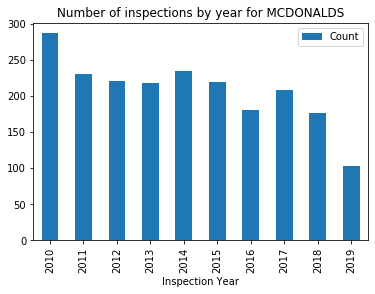

In [44]:
nb_inspections_by_year = df_mc[['Inspection Date', 'License #']].copy()
nb_inspections_by_year['Inspection Date'] = nb_inspections_by_year['Inspection Date'].apply(lambda x: x.year)
nb_inspections_by_year.rename(columns={'Inspection Date' : 'Inspection Year'}, inplace=True)
nb_inspections_by_year = nb_inspections_by_year.groupby('Inspection Year').count().rename(columns={'License #' : 'Count'})
nb_inspections_by_year.plot.bar()
plt.title("Number of inspections by year for MCDONALDS")

Text(0.5, 1.0, 'Number of inspections by year for BURGERKING')

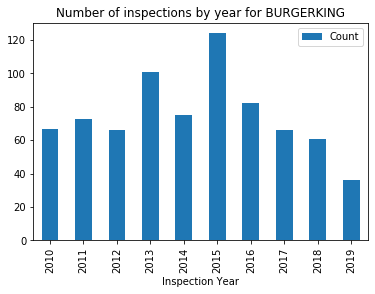

In [48]:
nb_inspections_by_year = df_bk[['Inspection Date', 'License #']].copy()
nb_inspections_by_year['Inspection Date'] = nb_inspections_by_year['Inspection Date'].apply(lambda x: x.year)
nb_inspections_by_year.rename(columns={'Inspection Date' : 'Inspection Year'}, inplace=True)
nb_inspections_by_year = nb_inspections_by_year.groupby('Inspection Year').count().rename(columns={'License #' : 'Count'})
nb_inspections_by_year.plot.bar()
plt.title("Number of inspections by year for BURGERKING")


Text(0.5, 1.0, 'Number of inspections by year for KFC')

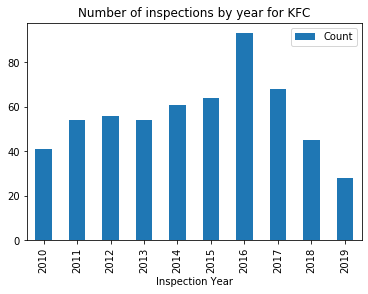

In [46]:
nb_inspections_by_year = df_kfc[['Inspection Date', 'License #']].copy()
nb_inspections_by_year['Inspection Date'] = nb_inspections_by_year['Inspection Date'].apply(lambda x: x.year)
nb_inspections_by_year.rename(columns={'Inspection Date' : 'Inspection Year'}, inplace=True)
nb_inspections_by_year = nb_inspections_by_year.groupby('Inspection Year').count().rename(columns={'License #' : 'Count'})
nb_inspections_by_year.plot.bar()
plt.title("Number of inspections by year for KFC")

Text(0.5, 1.0, 'Number of inspections by year for HAROLDSCHICKEN')

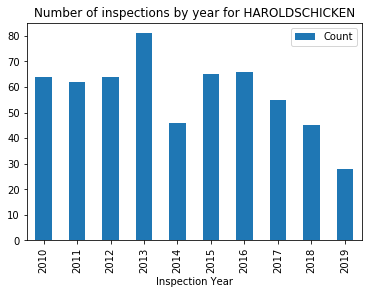

In [47]:
nb_inspections_by_year = df_hc[['Inspection Date', 'License #']].copy()
nb_inspections_by_year['Inspection Date'] = nb_inspections_by_year['Inspection Date'].apply(lambda x: x.year)
nb_inspections_by_year.rename(columns={'Inspection Date' : 'Inspection Year'}, inplace=True)
nb_inspections_by_year = nb_inspections_by_year.groupby('Inspection Year').count().rename(columns={'License #' : 'Count'})
nb_inspections_by_year.plot.bar()
plt.title("Number of inspections by year for HAROLDSCHICKEN")